# Cell painting data phenotype definition

In this notebook we load the [Rosetta](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10012424/) cell painting data (cpg-0003) and create a binary phenotype definition.

In [2]:
# Setup and imports
import numpy as np
import pandas as pd
# import dask.dataframe as dd
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
import pycytominer
%matplotlib inline

In [3]:
# Data locations
# We are interested in the genetic perturbation datasets, and there is one for each of the two cell lines
profile_uri_template = (
    "s3://cellpainting-gallery/cpg0003-rosetta/"
    "broad/workspace/preprocessed_data/"
    "{dataset}/CellPainting/"
    "replicate_level_cp_{processing}.csv.gz"
)

datasets = ("LUAD-BBBC041-Caicedo", "TA-ORF-BBBC037-Rohban")
processing_levels = ("augmented", "normalized", "normalized_variable_selected")

In [4]:
# Let's take a look at the A549 data
a549_profiles = pd.read_csv(
    profile_uri_template.format_map({'dataset': datasets[0], 'processing': 'augmented'}),
    storage_options={'anon': True}
)

a549_profiles

/tmp/ipykernel_463/1535658987.py:2: DtypeWarning: Columns (1814) have mixed types. Specify dtype option on import or set low_memory=False.
  a549_profiles = pd.read_csv(


,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_NCBIGeneID,Metadata_pert_type,Metadata_PublicID,Metadata_Transcript,Metadata_VirusPlateName,...,PublicID,Vector,Transcript,Symbol,x_mutation_status,NCBIGeneID,OtherDescriptions,InsertLength,pert_type,control_type
0,52657,a01,52657,DOC45.46.47.48,a01,NaN,control,EMPTY,NaN,DOC45.46.47.48,...,EMPTY,NaN,NaN,NaN,negcon,NaN,NaN,NaN,control,negcon
1,52665,a01,52665,DOC45.46.47.48,a01,NaN,control,EMPTY,NaN,DOC45.46.47.48,...,EMPTY,NaN,NaN,NaN,negcon,NaN,NaN,NaN,control,negcon
2,52653,a01,52653,DOC45.46.47.48,a01,NaN,control,EMPTY,NaN,DOC45.46.47.48,...,EMPTY,NaN,NaN,NaN,negcon,NaN,NaN,NaN,control,negcon
3,52663,a01,52663,DOC45.46.47.48,a01,NaN,control,EMPTY,NaN,DOC45.46.47.48,...,EMPTY,NaN,NaN,NaN,negcon,NaN,NaN,NaN,control,negcon
4,52649,a01,52649,DOC45.46.47.48,a01,NaN,control,EMPTY,NaN,DOC45.46.47.48,...,EMPTY,NaN,NaN,NaN,negcon,NaN,NaN,NaN,control,negcon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,52674,p24,52674,DOC49.50.51.52,p24,4193.0,trt,BRDN0000554157,NM_002392.3:c.662C>G,DOC49.50.51.52,...,BRDN0000554157,pLX_TRC317,NM_002392.3:c.662C>G,MDM2,MDM2_p.S221C,4193.0,E3 ubiquitin-protein ligase Mdm2|MDM2 oncogene...,1491.0,trt,NaN
6140,52652,p24,52652,DOC49.50.51.52,p24,4193.0,trt,BRDN0000554157,NM_002392.3:c.662C>G,DOC49.50.51.52,...,BRDN0000554157,pLX_TRC317,NM_002392.3:c.662C>G,MDM2,MDM2_p.S221C,4193.0,E3 ubiquitin-protein ligase Mdm2|MDM2 oncogene...,1491.0,trt,NaN
6141,52654,p24,52654,DOC49.50.51.52,p24,4193.0,trt,BRDN0000554157,NM_002392.3:c.662C>G,DOC49.50.51.52,...,BRDN0000554157,pLX_TRC317,NM_002392.3:c.662C>G,MDM2,MDM2_p.S221C,4193.0,E3 ubiquitin-protein ligase Mdm2|MDM2 oncogene...,1491.0,trt,NaN
6142,52662,p24,52662,DOC49.50.51.52,p24,4193.0,trt,BRDN0000554157,NM_002392.3:c.662C>G,DOC49.50.51.52,...,BRDN0000554157,pLX_TRC317,NM_002392.3:c.662C>G,MDM2,MDM2_p.S221C,4193.0,E3 ubiquitin-protein ligase Mdm2|MDM2 oncogene...,1491.0,trt,NaN


In [41]:
# CellProfiler features start with: 'Nuclei_', 'Cells_', 'Cytoplasm_'
# We will identigy control by Metadata_pert_type == 'control'
# Relevant metadata for deliverables: 'Metadata_Plate', 'Metadata_Well', 'Symbol', 'NCBIGeneID'
a549_feature_cols = a549_profiles.columns[
    a549_profiles.columns.str.startswith('Nuclei_') |
    a549_profiles.columns.str.startswith('Cells_') |
    a549_profiles.columns.str.startswith('Cytoplasm_')
]

In [27]:
# Get normalized profiles
normalized_a549_profiles = a549_profiles.groupby('Metadata_Plate').apply(
    pycytominer.normalize,
    # profiles is first positional argument
    # features=list(feature_cols),
    # image_features=True, # Include Image_### features
    method="standardize",
    samples="Metadata_pert_type == 'control'"
)

In [43]:
# Get SD counts
profiles_sd2 = (normalized_a549_profiles[a549_feature_cols].abs() > 2).sum(axis='columns')

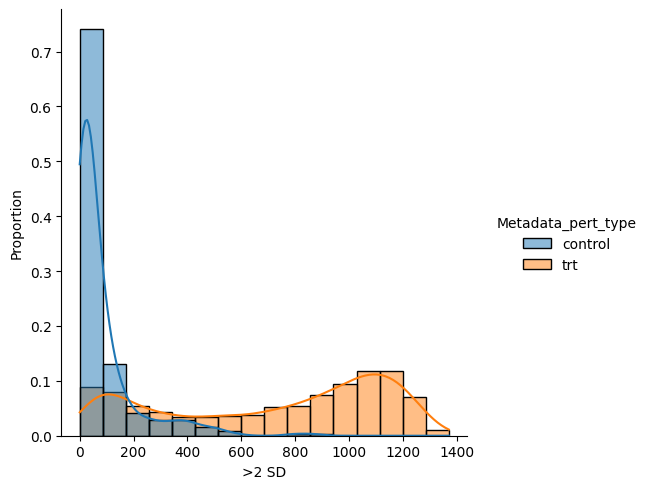

In [47]:
annotated_sd2 = normalized_a549_profiles[['Metadata_pert_type', 'Metadata_Plate']].copy()
annotated_sd2['>2 SD'] = profiles_sd2

sns.displot(
    data=annotated_sd2,
    x='>2 SD',
    hue='Metadata_pert_type',
    kde=True,
    common_norm=False,
    stat='proportion'
)

We define our thresholds based on the counts of features that are greater than 2 standard deviations from the mean.

* A positive label (representing morphological change) is given to counts above the point where the `CRISPR-trt` density surpasses 5 times the `CRISPR-no-guide` (control) density.
* A negative label (representing the absence of morphological change) is given to counts below the point where the `CRISPR-no-guide` density surpasses the the `CRISPR-trt` density.

In [49]:
control_kde = gaussian_kde(
    dataset = profiles_sd2[annotated_sd2['Metadata_pert_type'] == 'control'],
    bw_method='scott'
)

In [50]:
trt_kde = gaussian_kde(
    dataset = profiles_sd2[annotated_sd2['Metadata_pert_type'] == 'trt'],
    bw_method='scott'
)

In [51]:
range_array = np.arange(len(a549_feature_cols))
pt = np.where(control_kde(range_array)*5 < trt_kde(range_array))[0][0]
nt = np.where(control_kde(range_array) < trt_kde(range_array)*1)[0][0]

pt, nt

(556, 184)

In [52]:
labeled_df = annotated_sd2.copy()
labeled_df['label'] = 'Indeterminate'
labeled_df.loc[profiles_sd2 >= pt, 'label'] = 'Positive'
labeled_df.loc[profiles_sd2 <= nt, 'label'] = 'Negative'
labeled_df[['Metadata_pert_type', 'label']].value_counts().sort_index()

Metadata_pert_type  label        
control             Indeterminate      33
                    Negative          284
                    Positive            3
trt                 Indeterminate    1003
                    Negative         1045
                    Positive         3776
Name: count, dtype: int64

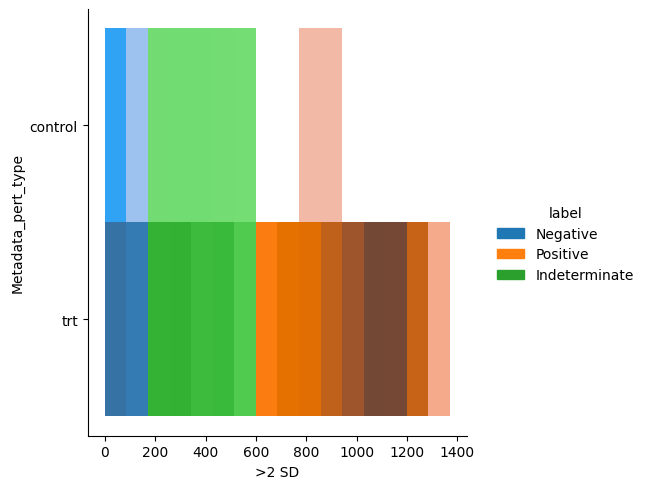

In [54]:
sns.displot(
    data=labeled_df,
    y='Metadata_pert_type',
    x='>2 SD',
    hue='label',
    #kind='kde'
)

### Linking well levels to CRISPR KOs

In [93]:
labeled_metadata = pd.concat(
    [
        labeled_df.reset_index('Metadata_Plate', drop=True)['label'],
        annotated_profiles[
            annotated_profiles.columns[
                annotated_profiles.columns.str.startswith('Metadata')
            ]
        ]
    ],
    axis='columns'
)

In [94]:
# Deliverable #1: Labeled wells
labeled_metadata.to_csv('data/well_labels.csv', index=False)

In [95]:
labeled_crispr_trt = labeled_metadata[labeled_metadata['Metadata_Perturbation'] == 'CRISPR-trt']

labeled_crispr_genes = (
    labeled_crispr_trt
    .groupby(['Metadata_Symbol', 'Metadata_NCBI_Gene_ID'])
    .label
    .value_counts()
    .unstack('label', fill_value=0)
)
labeled_crispr_genes

,label,Indeterminate,Negative,Positive
Metadata_Symbol,Metadata_NCBI_Gene_ID,,,
A2M,2,1,1,3
A3GALT2,127550,1,0,4
A4GALT,53947,0,0,5
A4GNT,51146,3,0,3
AACS,65985,1,0,4
...,...,...,...,...
ZSCAN32,54925,4,0,1
ZSCAN4,201516,0,0,3
ZSCAN5A,79149,0,0,5


We need a rule to find "surely positive" and "surely negative" genes.
The approach we will take is to label by the majority.

In [96]:
pls = labeled_crispr_genes['Positive']
nls = labeled_crispr_genes['Negative']
ils = labeled_crispr_genes['Indeterminate']

final_labeled_crispr_genes = labeled_crispr_genes.copy()
final_labeled_crispr_genes['gene_label'] = 'Indeterminate'
final_labeled_crispr_genes['gene_label'][pls > nls + ils] = 'Positive'
final_labeled_crispr_genes['gene_label'][nls > pls + ils] = 'Negative'

final_labeled_crispr_genes.gene_label.value_counts()

/tmp/ipykernel_572/3743650821.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_labeled_crispr_genes['gene_label'][pls > nls + ils] = 'Positive'
/tmp/ipykernel_572/3743650821.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_labeled_crispr_genes['gene_label'][nls > pls + ils] = 'Negative'


gene_label
Positive         6649
Indeterminate     979
Negative          347
Name: count, dtype: int64

In [97]:
# Deliverable #2: gene labels
final_labeled_crispr_genes.to_csv('data/gene_labels.csv')